Exercise 2.1. 
* P(greedy) + eps*(P(greedy)) => 0.5 + 0.25 = 0.75

Exercise 2.2
* Must have occurred: t=4, 5
* Might have occurred: t=1, 2, 3

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [13]:
class Bandit:
    """
        k_arm: # of arms
        epsilon: probability for exploration in epsilon-greedy algorithm
        initial: initial estimation for each action
        step_size: constant step size for updating estimations
        sample_averages: if True, use sample averages to update estimations instead of constant step size
        UCB_param: if not None, use UCB algorithm to select action
        gradient: if True, use gradient based bandit algorithm
        gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
        stationary: if False, rewards per action at each new step are not dependant on the previous experience
    """
    
    def __init__(self, k_arm=10, epsilon=0.05, step_size=0.1, initial=0., sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, stationary=True):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.initial = initial
        self.stationary = stationary
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.epsilon = epsilon

    def reset(self):
        
        # real reward for each action
        self.q_true = np.random.randn(self.k)

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        
        # exploration
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        # UCB
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-6))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        # gradient-based bandit
        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
#             print(self.action_prob)
            return np.random.choice(self.indices, p=self.action_prob)

        # exploitation
        q_best = np.max(self.q_estimation)
        
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        
        # generate the reward under N(real reward, 1)
        if self.stationary:
            reward = np.random.randn() + self.q_true[action]
        else:
            reward = np.random.randn() 
            
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages (for UCB)
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            pad_vector = np.zeros(self.k)
            pad_vector[action] = 1
            if self.gradient_baseline:
                # using average reward as baseline
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (pad_vector - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
            
        return reward

In [8]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [7]:
labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

In [9]:
runs = 2000
time = 1000

In [ ]:
bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.15it/s]


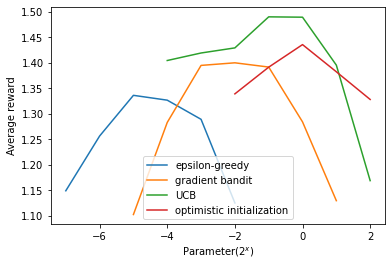

In [25]:
_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()

In [14]:
labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True, stationary=False),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True, stationary=False),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True, stationary=False),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1, stationary=False)]
parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

In [15]:
bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

In [16]:
runs = 2000
time = 1000

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.97it/s]


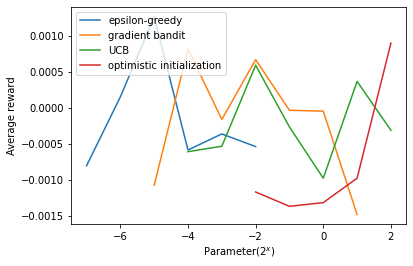

In [17]:
_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()